In [4]:
# ⚙️ 必要ライブラリ
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from types import SimpleNamespace
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import ot
from ot.unbalanced import sinkhorn_unbalanced
import os

In [5]:
# ── フォント設定（日本語ラベル用）──────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
else:
    font_prop = None

# ========= notebook parameters =========
args = SimpleNamespace(
    curr         = "../../data/shared/embeddings.npy",   # 既存サービスの埋め込み (n_services × D)
    fut          = "../VAE/emb_new.npy",      # 新規サンプルの埋め込み   (N_new × D)
    # segm         = "../../data/shared/user_segments.csv",# 市場セグメント（学生/高齢者など）
    mass_curr    = None,
    plot_detail  = True,
    sensitivity_analysis = True,   # 感度分析ON/OFF
)

In [6]:
# ──────────────────────────────────────────────
# 1. 埋め込みロード & 標準化
# ──────────────────────────────────────────────
X_curr = np.load(args.curr)
Y_fut  = np.load(args.fut)

scaler = StandardScaler()
X_curr = scaler.fit_transform(X_curr)
Y_fut  = scaler.transform(Y_fut)

In [9]:
# ──────────────────────────────────────────────
# 2. 質量ベクトルの構造：既存サービス＋非ユーザー＋残留ノード
#    + 市場セグメント対応
# ──────────────────────────────────────────────
xls      = pd.ExcelFile("../../data/定額制動画配信.xlsx")
df_raw   = pd.read_excel(xls, sheet_name="data")
format_df= pd.read_excel(xls, sheet_name="Format")

sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}
title_code = {v:k for k,v in code_title.items()}

counts = df_raw["SQ6_2"].value_counts().sort_index()
shares = counts / counts.sum()

import pickle
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")
mass_curr = []
for svc in feat_df.index:
    code = title_code.get(svc)
    mass_curr.append(shares.get(code, 0.0))
mass_curr = np.array(mass_curr, dtype=float)
service_names = feat_df.index.tolist()

# 非ユーザーの質量を市場調査や外部統計から決める
# ここでは例としてセグメント別の未利用率を仮定
# segment_df = pd.read_csv("../../data/shared/user_segments.csv")  # 例：学生,社会人,高齢者ごとの人口比と未利用率
# seg_population = segment_df["population"].values
# seg_nonuser_rate = segment_df["nonuser_rate"].values

# 仮のデータ
seg_population = np.array([0.3, 0.5, 0.2])
seg_nonuser_rate = np.array([0.6, 0.2, 0.4])

nonuser_mass = (seg_population * seg_nonuser_rate).sum() / seg_population.sum()   # 加重平均
print(f"推定される非ユーザー率: {nonuser_mass:.2%}")

# 「残留ノード」＝どこにも流れない人（無関心・娯楽別需要）も仮想的に設定
residual_mass = 0.1   # 例：10%は何があっても無反応とする

a = np.append(np.maximum(mass_curr, 1e-12), [nonuser_mass, residual_mass])
a /= a.sum()
all_source_names = service_names + ["(非ユーザー)", "(残留層)"]

n = X_curr.shape[0]
m = Y_fut.shape[0]

# 複数ARPU、サービスごとの単価も考慮（例）
# arpu_list = np.loadtxt("../../data/shared/arpu.csv")  # 新サービスごとのARPU仮定（円）

# arpu.csv をまだ作成していない場合、仮データで進める
# 仮の ARPU データ
arpu_list = np.array([1200, 1500, 1000, 1300, 1600])  # サービスごとの月額単価（仮）

# セグメント別分析（学生・社会人・高齢者…）のループにも対応可能

# 複数距離（コサイン×α＋価格差×β＋ブランド差×γ）で複合コスト
def composite_distance(X, Y, cosine_w=0.6, price_w=0.3, brand_w=0.1):
    # 仮：price_diff, brand_diffはデータがあれば計算
    D_cos = pairwise_distances(X, Y, metric="cosine")
    D_price = np.zeros_like(D_cos)  # 価格差が無い場合は0
    D_brand = np.zeros_like(D_cos)
    return (cosine_w * D_cos + price_w * D_price + brand_w * D_brand)

# パラメータ感度分析用の設定
param_grid = {
    "nonuser_mass": [0.1, 0.2, 0.3, 0.4],
    "D_nonuser":   [0.8, 1.0, 1.2],
    "residual_mass": [0.05, 0.1, 0.2],
    "eps": [0.1, 0.2, 0.3],
    "tau": [0.05, 0.1, 0.2]
}

total_market_size = 10000000   # 仮の全体市場規模

推定される非ユーザー率: 36.00%


In [10]:
# =============================================================
# 3. 新サービス候補1つずつに対してOTを実施 + パラメータ感度分析
# =============================================================

def run_ot_for_candidate(idx, nonuser_mass, D_nonuser, residual_mass, eps, tau):
    # 新サービスベクトル
    Y_single = Y_fut[idx].reshape(1, -1)
    # composite distance
    D_existing = composite_distance(X_curr, Y_single, cosine_w=0.7, price_w=0.2, brand_w=0.1)  # (n,1)
    # 非ユーザーと残留層から新サービスへのコスト（現実的ならセグメント別に分けて実装）
    D_nonuser_arr = np.array([[D_nonuser]])
    D_resid_arr   = np.array([[2.0]])   # 残留層は「絶対動かない」ので大きめコスト
    D = np.vstack([D_existing, D_nonuser_arr, D_resid_arr])  # (n+2, 1)
    D = D / np.median(D)

    # 質量ベクトル
    a_vec = np.append(np.maximum(mass_curr, 1e-12), [nonuser_mass, residual_mass])
    a_vec /= a_vec.sum()

    b = np.array([1.0])  # 1サービスだけに1

    # OT計算
    T = sinkhorn_unbalanced(a_vec, b, D, reg=eps, reg_m=tau)
    inbound_total  = T.sum()
    inbound_users  = inbound_total * total_market_size

    from_existing  = T[:-2, 0].sum()
    from_nonuser   = T[-2, 0]
    from_residual  = T[-1, 0]
    bo_ratio = from_nonuser / inbound_total if inbound_total > 0 else 0
    residual_ratio = from_residual / inbound_total if inbound_total > 0 else 0

    # Novelty
    novelty = D_existing.min()

    # ブルーオーシャンスコア
    blue_score = from_nonuser * novelty

    # 売上予測（単価は候補ごとに可変）
    try:
        arpu = arpu_list[idx]
    except:
        arpu = 1200
    estimated_sales = inbound_users * arpu

    return {
        "service": f"new{idx}",
        "from_existing": from_existing * total_market_size,
        "from_nonuser": from_nonuser * total_market_size,
        "from_residual": from_residual * total_market_size,
        "residual_ratio": residual_ratio,
        "total_inflow": inbound_users,
        "nonuser_ratio": bo_ratio,
        "novelty": novelty,
        "BlueOceanScore": blue_score,
        "estimated_sales": estimated_sales,
        "arpu": arpu,
        "eps": eps,
        "tau": tau,
        "nonuser_mass": nonuser_mass,
        "D_nonuser": D_nonuser,
        "residual_mass": residual_mass
    }

# グリッドサーチ・感度分析
if args.sensitivity_analysis:
    from itertools import product
    results = []
    for nonuser_mass, D_nonuser, residual_mass, eps, tau in product(
            param_grid["nonuser_mass"], param_grid["D_nonuser"],
            param_grid["residual_mass"], param_grid["eps"], param_grid["tau"]):
        print(f"Running for: nonuser={nonuser_mass:.2f}, D_nonuser={D_nonuser:.2f}, residual={residual_mass:.2f}, eps={eps:.2f}, tau={tau:.2f}")
        for idx in range(m):
            res = run_ot_for_candidate(idx, nonuser_mass, D_nonuser, residual_mass, eps, tau)
            results.append(res)
    df_result = pd.DataFrame(results)
    df_result.to_csv("results/scores_sensitivity.csv", index=False)
    # ここで最大値・安定性・パラメータ感度を多軸で分析
    # 例えば pivot_table やヒートマップで
else:
    # 1パターンだけ
    results = []
    for idx in range(m):
        res = run_ot_for_candidate(
            idx, nonuser_mass, D_nonuser=1.0, residual_mass=residual_mass,
            eps=0.2, tau=0.1)
        results.append(res)
    df_result = pd.DataFrame(results)
    df_result.to_csv("results/scores.csv", index=False)

Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.10, tau=0.05
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.10, tau=0.10
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.10, tau=0.20
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.20, tau=0.05
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.20, tau=0.10
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.20, tau=0.20
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.30, tau=0.05
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.30, tau=0.10
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.05, eps=0.30, tau=0.20
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.10, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05

=== Blue-Ocean Score TOP10 ===


,service,from_existing,from_nonuser,from_residual,residual_ratio,total_inflow,nonuser_ratio,novelty,BlueOceanScore,estimated_sales,arpu,eps,tau,nonuser_mass,D_nonuser,residual_mass
5035,new15,1.676586e+06,631821.562694,3595.431842,0.001555,2.312003e+06,0.273279,0.474917,0.030006,2.774403e+09,1200,0.3,0.2,0.4,0.8,0.05
5215,new15,1.635748e+06,616431.774524,7015.710009,0.003105,2.259195e+06,0.272855,0.474917,0.029275,2.711034e+09,1200,0.3,0.2,0.4,0.8,0.10
5395,new15,1.560670e+06,588138.713307,13387.404181,0.006192,2.162196e+06,0.272010,0.474917,0.027932,2.594635e+09,1200,0.3,0.2,0.4,0.8,0.20
5033,new13,1.591125e+06,665075.118321,4032.185841,0.001784,2.260232e+06,0.294251,0.405642,0.026978,2.712279e+09,1200,0.3,0.2,0.4,0.8,0.05
5037,new17,1.563477e+06,543854.708598,2339.418795,0.001109,2.109671e+06,0.257791,0.486354,0.026451,2.531605e+09,1200,0.3,0.2,0.4,0.8,0.05
5213,new13,1.552267e+06,648832.990623,7867.427681,0.003562,2.208968e+06,0.293727,0.405642,0.026319,2.650761e+09,1200,0.3,0.2,0.4,0.8,0.10
5217,new17,1.525588e+06,530675.161393,4565.452600,0.002215,2.060829e+06,0.257506,0.486354,0.025810,2.472994e+09,1200,0.3,0.2,0.4,0.8,0.10
5393,new13,1.480829e+06,618972.361535,15010.704947,0.007098,2.114812e+06,0.292684,0.405642,0.025108,2.537774e+09,1200,0.3,0.2,0.4,0.8,0.20
5397,new17,1.455936e+06,506446.599712,8714.023619,0.004421,1.971096e+06,0.256937,0.486354,0.024631,2.365315e+09,1200,0.3,0.2,0.4,0.8,0.20
5027,new7,1.425283e+06,589574.353571,2786.924339,0.001381,2.017645e+06,0.292209,0.414993,0.024467,2.421173e+09,1200,0.3,0.2,0.4,0.8,0.05


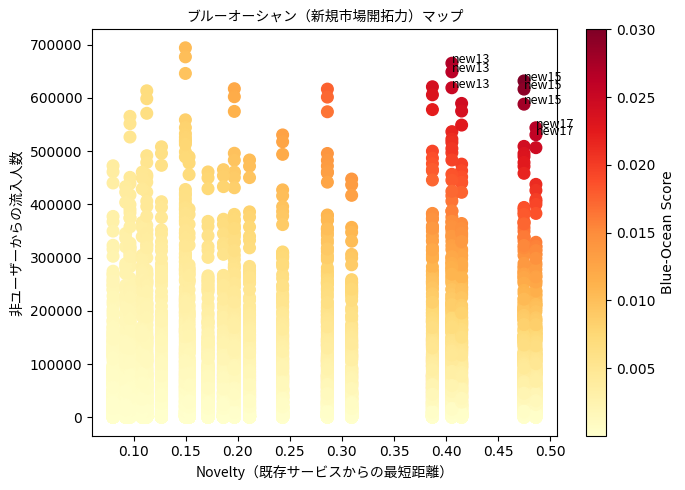

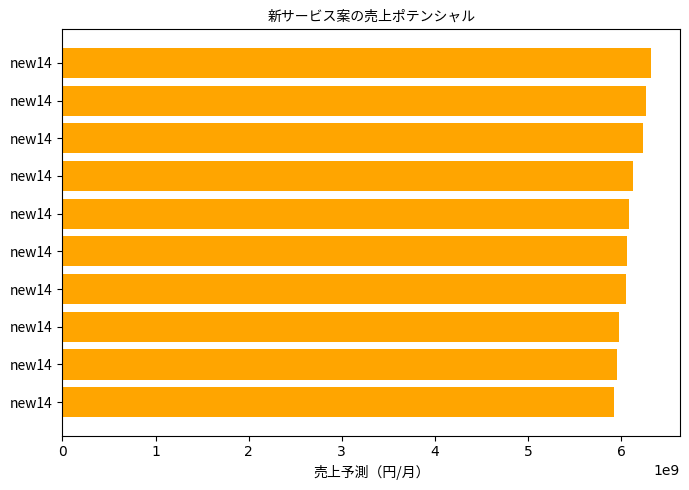

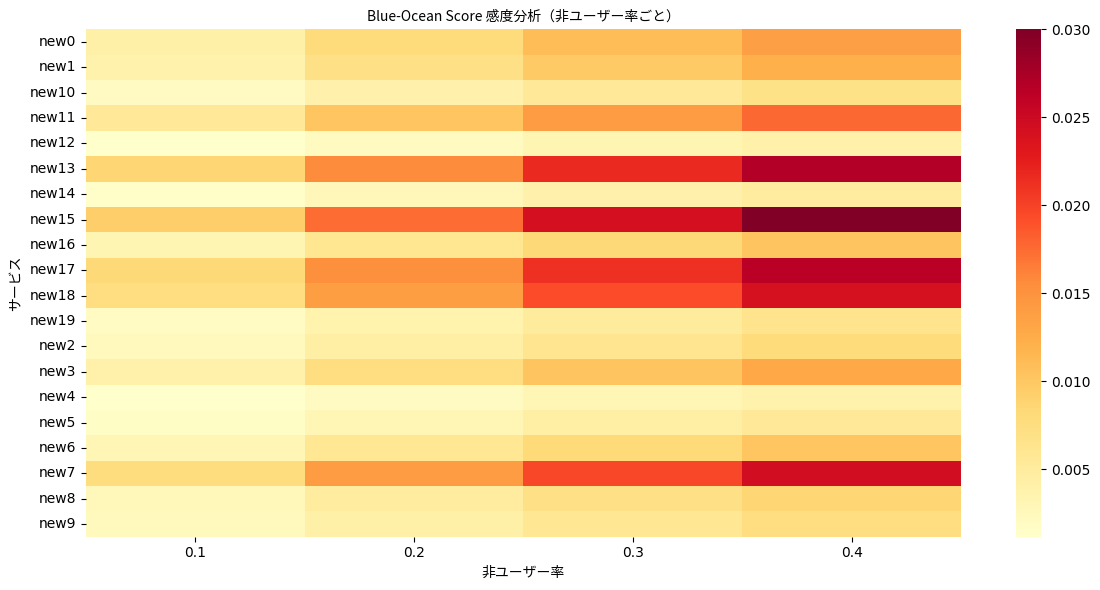

In [11]:
# =============================================================
# 4. 可視化・ランキング出力
# =============================================================

print("=== Blue-Ocean Score TOP10 ===")
display(df_result.sort_values("BlueOceanScore", ascending=False).head(10))

plt.figure(figsize=(7,5))
plt.scatter(df_result["novelty"], df_result["from_nonuser"], 
            c=df_result["BlueOceanScore"], cmap="YlOrRd", s=70)
plt.colorbar(label="Blue-Ocean Score")
for _, row in df_result.sort_values("BlueOceanScore", ascending=False).head(8).iterrows():
    plt.text(row.novelty, row.from_nonuser, row.service, fontsize=9,
             fontproperties=font_prop)
plt.xlabel("Novelty（既存サービスからの最短距離）", fontproperties=font_prop)
plt.ylabel("非ユーザーからの流入人数", fontproperties=font_prop)
plt.title("ブルーオーシャン（新規市場開拓力）マップ", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# 売上予測上位
plt.figure(figsize=(7,5))
order = np.argsort(df_result["estimated_sales"])[::-1][:10]
plt.barh(range(10), df_result.iloc[order]["estimated_sales"], color="orange")
plt.yticks(range(10), df_result.iloc[order]["service"], fontproperties=font_prop)
plt.xlabel("売上予測（円/月）", fontproperties=font_prop)
plt.title("新サービス案の売上ポテンシャル", fontproperties=font_prop)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 感度分析結果ヒートマップ（例：パラメータごと最大値など集約）
if args.sensitivity_analysis:
    pivot = df_result.pivot_table(index="service", columns="nonuser_mass", values="BlueOceanScore", aggfunc="max")
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="YlOrRd")
    plt.title("Blue-Ocean Score 感度分析（非ユーザー率ごと）", fontproperties=font_prop)
    plt.ylabel("サービス", fontproperties=font_prop)
    plt.xlabel("非ユーザー率", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

In [12]:
new14_vec = Y_fut[14]
existing_features = feat_df.values  # 既存サービス特徴行列

diffs = np.abs(existing_features - new14_vec)
avg_diff = diffs.mean(axis=0)       # 特徴ごとの平均差分

# 差分が大きい特徴をランキング
top_diff_indices = np.argsort(avg_diff)[::-1][:10]
print("new14が特に異なる特徴トップ10:")
for idx in top_diff_indices:
    print(f"{feat_df.columns[idx]}: 差分 {avg_diff[idx]:.3f}")


ValueError: operands could not be broadcast together with shapes (20,33) (64,) 

In [13]:
# vae_decoder: latent_dim → feat_dim の変換モデル
# Y_fut: (n_new, latent_dim) の潜在ベクトル

feat_reconstructed = vae_decoder.predict(Y_fut)  # (n_new, feat_dim)
new14_feat_vec = feat_reconstructed[14]


NameError: name 'vae_decoder' is not defined

In [14]:
new14_vec = Y_fut[14]
diffs = np.abs(X_curr - new14_vec)   # X_curr と同じ64次元の空間
avg_diff = diffs.mean(axis=0)


In [15]:
top_diff_indices = np.argsort(avg_diff)[::-1][:10]
feature_names = [f"dim_{i}" for i in range(X_curr.shape[1])]

print("new14が特に異なる埋め込み次元トップ10:")
for idx in top_diff_indices:
    print(f"{feature_names[idx]}: 差分 {avg_diff[idx]:.3f}")


new14が特に異なる埋め込み次元トップ10:
dim_42: 差分 1.296
dim_35: 差分 1.228
dim_19: 差分 1.213
dim_36: 差分 1.213
dim_6: 差分 1.155
dim_26: 差分 1.134
dim_50: 差分 1.112
dim_25: 差分 1.109
dim_13: 差分 1.105
dim_27: 差分 1.100
